<img src="https://i.imgur.com/qlmILqC.png" style="center; margin: 20px;">

# Data Cleaning
In this notebook I am cleaning the `RAW_recipes.csv` data. Though I ran this cleaning notebook on Jupyter, the codes are easily adjustable to be run on Google Colab. Simply mount your Google Drive (see [1. Import Libraries](#import)) and edit the file paths.

---
## DIRECTORY
1. [Import Libraries](#import)
2. [Read Data](#read)
3. [Drop Irrelevant Columns](#drop)
4. [Missing Values](#null)
5. [Data Types](#type)
6. [Duplicates](#duplicate)
7. [Outliers](#outlier)
8. [Exploratory Data Analysis: `tags`](#tags)
9. [Save Cleaned Data](#save)

---
<a id='import'></a>
## 1. Import Libraries
Along with the customary libraries, Pandas, Numpy and Matplotlib, I will need,
- `MultiLabelBinarizer` from Scikit-learn to binarize the `tags` to build the recipe recommender upon,
- `os` module to interface with the underlying operating system that Python is running on, and
- The python file, `functions`, in the assets directory.

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MultiLabelBinarizer

import os
os.chdir('../assets')
import functions as f
os.chdir('../code')

When using Google Colab, save your [data](https://www.kaggle.com/shuyangli94/food-com-recipes-and-user-interactions) data to your Google Drive and read it by importing the `drive` method. Simply follow the instructions to authorize your Google account.

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

<a id='read'></a>
## 2. Read Data
The [Kaggle data](https://www.kaggle.com/shuyangli94/food-com-recipes-and-user-interactions) has 200K+ recipes. Yet, due to limited computer storage, I'm only using approx. 15% of the available data. This brings my data set to 30,000 recipes. To keep the sample as accurate as possible, I'm randomly sampling the original data.

In [3]:
df = pd.read_csv('../data/RAW_recipes.csv')
df = df.sample(30_000, random_state = 42)
df.head(1)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
59957,crab filled crescent snacks,94947,70,111448,2004-07-03,"['time-to-make', 'course', 'main-ingredient', ...","[69.2, 3.0, 9.0, 6.0, 5.0, 4.0, 3.0]",16,"['heat over to 375 degrees', 'spray large cook...",found in a crescent roll recipe magazine.,"['crabmeat', 'cream cheese', 'green onions', '...",9


<a id='drop'></a>
## 3. Drop Irrelevant Columns

For the purpose of my recommender system, I only need the `name` and `tags` columns. However, I need the following columns to perform data cleaning and exploration:
```
['name','id','minutes', 'tags', 'steps','ingredients']
```
In the interest of efficiency, I am dropping the irrelevant columns from my data.

In [4]:
df = df[['name','id','minutes', 'tags', 'steps','ingredients']]

df.head(1)

,name,id,minutes,tags,steps,ingredients
59957,crab filled crescent snacks,94947,70,"['time-to-make', 'course', 'main-ingredient', ...","['heat over to 375 degrees', 'spray large cook...","['crabmeat', 'cream cheese', 'green onions', '..."


<a id='null'></a>
## 4. Missing Values

No missing values found.

In [5]:
df.isna().sum()

name           0
id             0
minutes        0
tags           0
steps          0
ingredients    0
dtype: int64

<a id='type'></a>
## 5. Data types
All data types are correct.

In [6]:
df.dtypes

name           object
id              int64
minutes         int64
tags           object
steps          object
ingredients    object
dtype: object

<a id='duplicate'></a>
## 6. Duplicates
No ducplicate recipes found.

In [7]:
df[df.duplicated()]

,name,id,minutes,tags,steps,ingredients


<a id='outlier'></a>
## 7. Outliers
I'm using a boxplot to check the distribution of `minutes` (cooking time), to see if there are outliers. To interpret the boxplot below, it is important to understand that,
>The upper and lower whiskers represent scores outside the middle 50%. Whiskers often (but not always) stretch over a wider range of scores than the middle quartile (box) groups." 

Source: [Wellbeing@School](https://www.wellbeingatschool.org.nz/information-sheet/understanding-and-interpreting-box-plots#:~:text=The%20upper%20and%20lower%20whiskers,than%20the%20middle%20quartile%20groups.)

With that in mind, recipes that require more than 2 hours (rounded up) to cook are considered outliers because they are beyond the upper extremes (upper whisker). These outliers amount to 11% of the 30,000 data.

<img src='../plots/boxplot_minutes.png' alt="boxplot_minutes" width="45%" height="45%">
I will investigate further the recipes that takes longer than 2 hours to find an explaination and handle them appropriately.

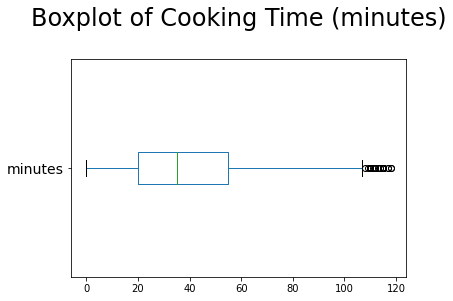

In [8]:
plt.figure(figsize=(6, 4))

df[df.minutes < 120]['minutes'].plot(kind='box', vert=False)

plt.title('Boxplot of Cooking Time (minutes)\n', fontsize=24)
plt.xlabel('', fontsize=14)
plt.yticks(fontsize=14)

plt.savefig('../plots/boxplot_minutes.png', dpi=235, bbox_inches='tight');

In [9]:
print(f"{round(df[df.minutes > 120].shape[0]/df.shape[0],2)} out of the 30,000 recipe data are considered outliers.")

0.11 out of the 30,000 recipe data are considered outliers.


#### Investigating Outliers
My assumption is that the outliers are justified because recipes that involves braising, fermenting, smoking, or freezing will be time-consuming. To investigate, I dug into recipe samples that takes (approx.) 4 different cooking time(s): 
- 12 hours
- 1 day
- 1 month
- 3 months

**Define a function that fetches time-consuming recipe details**

In [10]:
def get_deets(index, unit):
    """
    index = index of recipe in DataFrame
    unit  = desired time unit
    """
    unit_conversions = {'hour': 60,
                        'day':1440,
                        'month':43800}
    
    name = df.loc[index]['name']
    time = df.loc[index]['minutes']
    recipe = df.loc[index]['steps'][2:-2].split("', '")
    
    print(f'Name: {name.title() }')
    print('Cooking Time: '+str(round(time/unit_conversions[unit]))+' '+ unit)
    print(f'Recipe Steps: {recipe}')

**Recipe that requires 12 hours**

In [11]:
get_deets(89734, 'hour')

Name: Garden Minestrone
Cooking Time: 12.0 hour
Recipe Steps: ['microwave onion , garlic , oil , oregano , and red pepper flakes in bowl , stirring occasionally , until onion is softened , about 5 minutes', 'transfer to slow cooker', 'stir broth , tomato sauce , soaked beans , and carrots into slow cooker', 'cover and cook until beans are tender , 9-11 hours on low or 5-7 hours on high', 'stir in zucchini , chard , and pasta', 'cover and cook on high until vegetables and pasta are tender , 20-30 minutes', 'stir in basil', 'season with salt and pepper to taste', 'serve with parmesan cheese and additional olive oil']


**Recipe that requires 1 day**

In [12]:
get_deets(178579, 'day')

Name: Salad Bar Antipasto
Cooking Time: 1.0 day
Recipe Steps: ['combine and seal all ingredients in a large heavy plastic bag , except for the parmesan cheese', 'seal the bag and refrigerate for 24 hours , turning bag occasionally', 'turn out into a large serving bowl', 'top with the parmesan cheese , if desired']


**Recipe that requires 1 month**

In [13]:
get_deets(106494, 'month')

Name: Homemade Creme De Menthe
Cooking Time: 1.0 month
Recipe Steps: ['boil sugar and water together', 'let cool', 'combine all other ingredients in a large pitcher', 'add sugar syrup , stirring to combine , and pour into clean sterilized bottles for storage', 'age for a month']


**Recipe that requires more than 3 months**

The masked DataFrame below shows that there is only 1 recipe that takes more than 3 months to make, so all outliers are accounted for. 

In [14]:
df[df['minutes']>131400].sort_values('minutes').head(1)

,name,id,minutes,tags,steps,ingredients
145524,nut wine,242032,132495,"['time-to-make', 'course', 'cuisine', 'prepara...",['make a mixture of the nuts and alcohol and h...,"['walnuts', 'everclear alcohol', 'sugar']"


In [15]:
get_deets(145524, 'month')

Name: Nut Wine
Cooking Time: 3.0 month
Recipe Steps: ['make a mixture of the nuts and alcohol and have it sit for 3 months', 'filter out the nuts', 'add the sugar', 'let mixture settle for another 2 to 3 days']


#### Investigating Outliers: Findings
My assumption was correct, all time-consuming recipes are justified. The following are a quotes from recipe instructions (`steps`) to support,

| Justified | Name                     | Cooking Time | Quote                                                                         |
|-----------|--------------------------|--------------|-------------------------------------------------------------------------------|
|    YES    | Garden Minestrone        | 12.0 hour    | Cover and cook until beans are tender , 9-11 hours on low or 5-7 hours on high|
|    YES    | Salad Bar Antipasto      | 1.0 day      | Seal the bag and refrigerate for 24 hours , turning bag occasionally.         |
|    YES    | Homemade Creme De Menthe | 1.0 month    | Age for a month.                                                              |
|    YES    | Nut Wine                 | 3.0 month    | Make a mixture of the nuts and alcohol and have it sit for 3 months           |

<a id='tags'></a>
## 8. Exploratory Data Analysis: `tags`
For my recommender system, I'm only using `tags` as my variables. In order to do so, I convert the data from `strings` into `list` structures and then binarize them using `MultiLabelBinarizer`. Using this method, I succesfully keep each tag unaltered.

**Convert `tags` column into `list` structure**

In [16]:
f.make_lists(df, 'tags')

59957     [time-to-make, course, main-ingredient, prepar...
68281     [curries, 30-minutes-or-less, time-to-make, co...
71122     [lactose, 30-minutes-or-less, time-to-make, co...
163767    [15-minutes-or-less, time-to-make, course, mai...
136941    [15-minutes-or-less, time-to-make, course, mai...
                                ...                        
82308     [time-to-make, course, main-ingredient, cuisin...
137997    [60-minutes-or-less, time-to-make, course, pre...
158674    [weeknight, 15-minutes-or-less, time-to-make, ...
132795    [60-minutes-or-less, time-to-make, course, mai...
40347     [15-minutes-or-less, time-to-make, course, mai...
Name: tags, Length: 30000, dtype: object

**Vectorize `tags`**

In [17]:
mlb = MultiLabelBinarizer()

tags_df = pd.DataFrame(mlb.fit_transform(df['tags']), columns=mlb.classes_, index=df['tags'].index)
tags_df.head()

,,1-day-or-more,15-minutes-or-less,3-steps-or-less,30-minutes-or-less,4-hours-or-less,5-ingredients-or-less,60-minutes-or-less,a1-sauce,african,...,whitefish,whole-chicken,whole-duck,whole-turkey,wild-game,wings,winter,yams-sweet-potatoes,yeast,zucchini
59957,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
68281,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
71122,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
163767,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
136941,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Quick Glance
There are 497 unique tags from binarizing raw `tags` list. However, there's a bit of cleaning to do to handle the blank tag, `''`, and duplicate tags 'healthy' and 'healthy-2'.

#### Clean `tags`

In [18]:
# drop

tags_df.drop(columns=[""], inplace=True)

In [19]:
# combine

for i in list(tags_df.index):
    if tags_df.loc[i, 'healthy-2'] == 1:
        tags_df.loc[i, 'healthy'] = 1
        
tags_df.drop(columns = 'healthy-2', inplace=True)

tags_df.head()

,1-day-or-more,15-minutes-or-less,3-steps-or-less,30-minutes-or-less,4-hours-or-less,5-ingredients-or-less,60-minutes-or-less,a1-sauce,african,american,...,whitefish,whole-chicken,whole-duck,whole-turkey,wild-game,wings,winter,yams-sweet-potatoes,yeast,zucchini
59957,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
68281,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
71122,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
163767,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
136941,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Plot the Distribution of `tags`
There are 495 tags after cleaning. Shown on the boxplot below, tags that occur more than approx. 400 times (beyond the upper whisker) are extremely popular tags.

In [20]:
# Find sum of each tags

tags_dict = {}

for col in tags_df.columns:
    tags_dict[col] = tags_df[col].sum()
    
tags_freq = pd.DataFrame(tags_dict.items(), columns=['tags', 'frequency'])

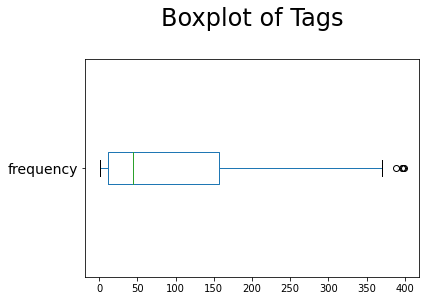

In [21]:
# Boxplot of Tags

tags_freq[(tags_freq['frequency'] < 400)].plot(kind='box', figsize=(6,4), vert=False)
plt.title('Boxplot of Tags\n', fontsize=24)
plt.xlabel('', fontsize=14)
plt.yticks(fontsize=14);

plt.savefig('../plots/boxplot_tags.png', dpi=235, bbox_inches='tight')

#### Plot the `tags` Within Boxplot Whiskers
Displayed below are the top and bottom 5 of tags that are within the boxplot whiskers (lower and upper extremes). These tags range from occuring in 0 - 400 recipes and are still easily interpretable. As we can see, they may imply the type of food, cuisine, or ingredients in a recipe.

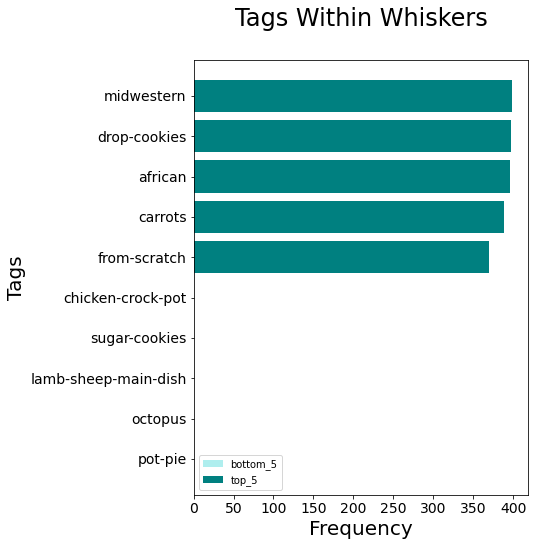

In [22]:
plt.figure(figsize=(6,8))

head_in_whisker = tags_freq[(tags_freq['frequency'] < 401)].sort_values('frequency').head(5)
tail_in_whisker = tags_freq[(tags_freq['frequency'] < 401)].sort_values('frequency').tail(5)

plt.barh(head_in_whisker.tags, head_in_whisker.frequency, label='bottom_5', color='paleturquoise')
plt.barh(tail_in_whisker.tags, tail_in_whisker.frequency, label='top_5', color='teal')

plt.title('Tags Within Whiskers\n', fontsize=24)
plt.xlabel('Frequency', fontsize=20)
plt.ylabel('Tags', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend();

plt.savefig('../plots/within_whiskers_tags.png', dpi=235, bbox_inches='tight')

#### Plot Infrequent Tags

However, infrequent tags would only have a small amount of recipes to compare to and recommend from in a recipe recommender. Hence, I will drop them from my data since they are invaluable.

I'm dropping tags with up to 0.05% (15 or less) of recipes tagged with it.

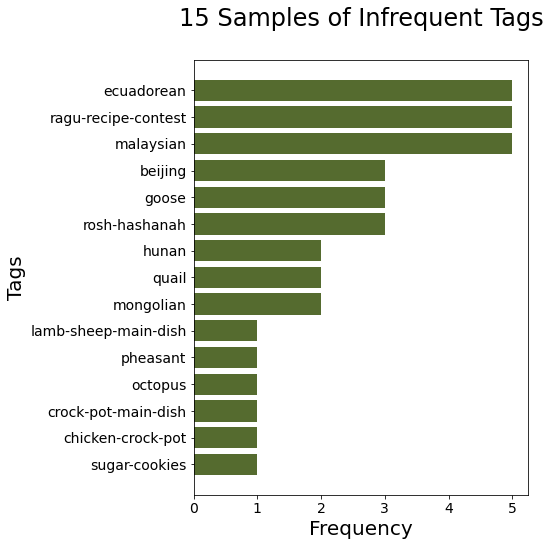

In [23]:
least_freq_tags = tags_freq[tags_freq['frequency']<6].sample(15, random_state=42).sort_values('frequency')

plt.figure(figsize=(6,8))

plt.barh(least_freq_tags['tags'], least_freq_tags['frequency'],\
         color=('darkolivegreen'))

plt.title('15 Samples of Infrequent Tags\n', fontsize=24)
plt.xlabel('Frequency', fontsize=20)
plt.ylabel('Tags', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

plt.savefig('../plots/infreq_tags.png', dpi=235, bbox_inches='tight')

In [24]:
tags_col = list(tags_freq[(tags_freq['frequency'] > 15)]['tags'])

tags_df = tags_df[tags_col]

tags_df.sum()

1-day-or-more           261
15-minutes-or-less     5662
3-steps-or-less        5816
30-minutes-or-less     7072
4-hours-or-less        6443
                       ... 
wings                    84
winter                  950
yams-sweet-potatoes     200
yeast                   422
zucchini                 22
Length: 398, dtype: int64

#### Plot the `tags` Beyond Boxplot Whiskers
Displayed below are the top and bottom 5 of tags that are beyond the upper boxplot whisker. These tags range from occuring in 401 -  30,000 (all data) recipes. While the bottom 5 tags are still descriptive like the tags within the boxplot whiskers, the top 5 are too generic to be of value. I will explore these generic tags more in my next step.

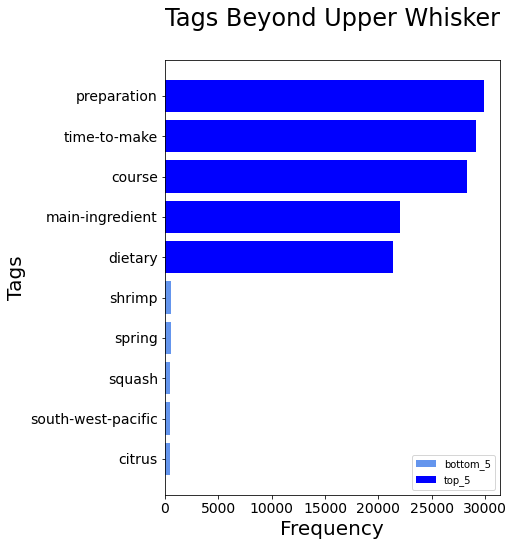

In [25]:
plt.figure(figsize=(6,8))

head_beyond_whisker = tags_freq[(tags_freq['frequency'] > 450)].sort_values('frequency').head(5)
tail_beyond_whisker = tags_freq[(tags_freq['frequency'] > 450)].sort_values('frequency').tail(5)

plt.barh(head_beyond_whisker.tags, head_beyond_whisker.frequency, label='bottom_5', color='cornflowerblue')
plt.barh(tail_beyond_whisker.tags, tail_beyond_whisker.frequency, label='top_5', color='blue')

plt.title('Tags Beyond Upper Whisker\n', fontsize=24)
plt.xlabel('Frequency', fontsize=20)
plt.ylabel('Tags', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc = 'lower right');

plt.savefig('../plots/beyond_upper_whisker_tags.png', dpi=235, bbox_inches='tight')

#### Plot 15 Most Frequent Tags
The bar graph below shows the 15 most popular tags, sorted in descending order. We can discern that, the more popular the tag, the less descriptive (more generic) it becomes. These tags are in dark green. Additionally, we start to see more interpretable tags towards the bottom 4.

Because the tags in dark green don't differentiate recipes that well, they wouldn't be of value to my recipe recommender, and hence they will be removed from my data. Which will bring us to 388 tags.

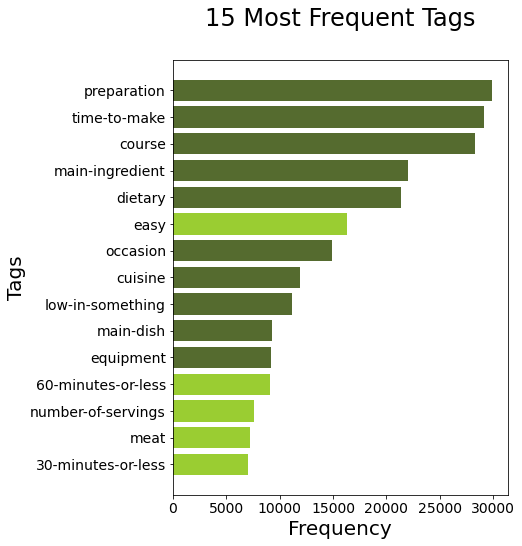

In [26]:
most_freq_tags = tags_freq.sort_values('frequency').tail(15)

plt.figure(figsize=(6,8))

plt.barh(most_freq_tags['tags'], most_freq_tags['frequency'],\
         color=('yellowgreen','yellowgreen','yellowgreen','yellowgreen','darkolivegreen','darkolivegreen','darkolivegreen','darkolivegreen','darkolivegreen','yellowgreen','darkolivegreen','darkolivegreen','darkolivegreen','darkolivegreen','darkolivegreen'))

plt.title('15 Most Frequent Tags\n', fontsize=24)
plt.xlabel('Frequency', fontsize=20)
plt.ylabel('Tags', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

plt.savefig('../plots/most_freq_tags.png', dpi=235, bbox_inches='tight')

In [27]:
tags_to_drop = ['equipment','main-dish','low-in-something','cuisine','occasion','dietary',\
 'main-ingredient','course','time-to-make','preparation']

tags_df.drop(columns=tags_to_drop, inplace=True)

tags_df.shape[1]

388

#### `tags` Summary
After examining the different tags available, I decided that I will only use the vectorized tags as vairables in my recipe recommender because they already comprise of the most relevant features:
1. Time Requirement
2. Level of Difficulty
3. Main Ingredients
4. Others (Cuisine, food type, dietary restrictions, occasions)

The bar chart below summarizes the different tags available.

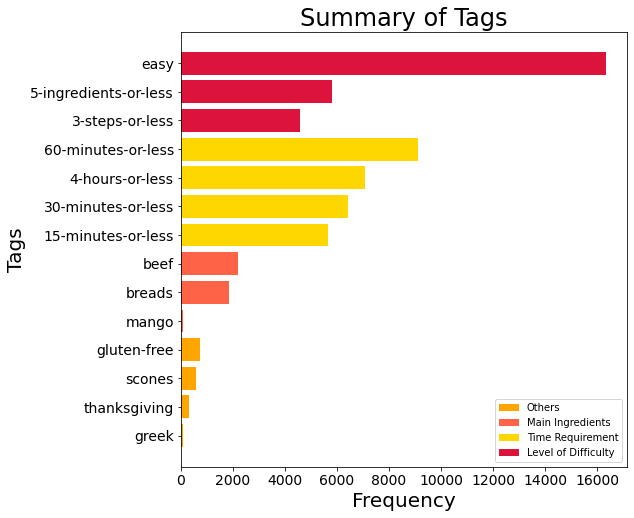

In [28]:
plt.figure(figsize=(8,8))

ingredients = tags_df[[
    'mango',
    'breads',
    'beef']]

others = tags_df[[
    'greek',
    'thanksgiving',
    'scones',
    'gluten-free']]

time = tags_df[[
    '15-minutes-or-less',
    '30-minutes-or-less',
    '4-hours-or-less',
    '60-minutes-or-less']]

level = tags_df[[
    '3-steps-or-less',
    '5-ingredients-or-less',
    'easy']]


plt.barh(others.columns, others.sum().sort_values(), label='Others', color='orange')
plt.barh(ingredients.columns, ingredients.sum().sort_values(), label='Main Ingredients', color='tomato')
plt.barh(time.columns, time.sum().sort_values(), label='Time Requirement', color='gold')
plt.barh(level.columns, level.sum().sort_values(), label='Level of Difficulty', color='crimson')

plt.title('Summary of Tags', fontsize=24)
plt.xlabel('Frequency', fontsize=20)
plt.ylabel('Tags', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend();

plt.savefig('../plots/tags_summary.png', dpi=235, bbox_inches='tight')

<a id='outlier'></a>
## 8. Save Data
I'm saving two CSV files, one as the DataFrame to pull recommendation details, `cleaned_recipes.csv`, and another to build the recommender system upon, `ready.csv`. Make sure to reset the index if you have dropped row(s) of data when cleaning.

**cleaned_recipes.csv**

In [29]:
df.drop(columns=['id','tags']).reset_index(drop = True).to_csv('../data/cleaned_recipes.csv', index = False)

# Sanity Check
pd.read_csv('../data/cleaned_recipes.csv').head(0)

,name,minutes,steps,ingredients


**ready.csv**

In [30]:
ready = pd.concat([df[['name']], tags_df], axis=1)

ready.to_csv('../data/ready.csv', index = False)

# Sanity Check
pd.read_csv('../data/ready.csv').head(0)

,name,1-day-or-more,15-minutes-or-less,3-steps-or-less,30-minutes-or-less,4-hours-or-less,5-ingredients-or-less,60-minutes-or-less,african,american,...,welsh,white-rice,whole-chicken,whole-turkey,wild-game,wings,winter,yams-sweet-potatoes,yeast,zucchini
